In [1]:
import os
import sys
import subprocess
import importlib.util

PKG_DIR = "./python_packages" 
os.makedirs(PKG_DIR, exist_ok=True)

if PKG_DIR not in sys.path:
    sys.path.append(PKG_DIR)

def is_installed(pkg_name):
    return importlib.util.find_spec(pkg_name) is not None

# Install packages to that directory using pip
def install_package(pkg_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--target", PKG_DIR, pkg_name])

required_packages = ["numpy", "pandas", "matplotlib", "uproot", "scikit-learn", "seaborn", "xgboost"]
for pkg in required_packages:
    if not is_installed(pkg):
        print(f"Installing {pkg}...")
        install_package(pkg)
    else:
        print(f"{pkg} already installed.")

numpy already installed.
pandas already installed.
matplotlib already installed.
uproot already installed.
Installing scikit-learn...
  Using cached scikit_learn-1.6.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-2.2.5-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
Using cached joblib-1.5.0-py3-none-any.whl (307 kB)
Using cached numpy-2.2.5-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
Using cached scipy-1.15.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


seaborn already installed.
xgboost already installed.


In [2]:
from Tools.PlotTools import *

import math
import random

import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rcParams
rcParams['figure.constrained_layout.use'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
import seaborn as sns

import pandas as pd
import uproot

Loading .rootlogon.C
Loading sPhenixStyle.C
sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode
Loading paul_tol_colors.hpp
Loading RooDoubleCB.cxx


In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    import Configs.TrainConfig as Conf
    importlib.reload(Conf)  # Force reload in case file was updated
    TrainConfig = "Configs/TrainConfig"
else:
    print("Not in IPython")
    TrainConfig = sys.argv[1]
    print(f"Importing settings from {TrainConfig.replace('/', '.')}")
    import importlib.util
    import_path = TrainConfig.replace("/", ".")
    Conf = importlib.import_module(import_path)
    importlib.reload(Conf)

# Set defaults if not defined in the config
if not hasattr(Conf, 'RandomState'): Conf.RandomState = 42
if not hasattr(Conf, 'MVAlogplot'):  Conf.MVAlogplot = False
if not hasattr(Conf, 'Multicore'):   Conf.Multicore = False

# Make output directory to store configuration, trainer, and training results
prGreen("Making output directory: {}".format(Conf.OutputDirName))
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/Trainer-Config")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/Trainer-Config/")

if in_ipynb():
    os.system("cp Trainer.ipynb ./"+ Conf.OutputDirName+"/Trainer-Config/")
else:
    os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/Trainer-Config/")

if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd)

{'IPKernelApp': {'connection_file': '/direct/sphenix+u/hjheng/.local/share/jupyter/runtime/kernel-28b2e4c4-11dc-4ab4-bc34-90e024732c64.json'}}
In IPython
 Making output directory: ./Output_TEST
{'IPKernelApp': {'connection_file': '/direct/sphenix+u/hjheng/.local/share/jupyter/runtime/kernel-28b2e4c4-11dc-4ab4-bc34-90e024732c64.json'}}


In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode: Only every 10th event will be used")
else:
    prGreen("Running in non-debug mode")

 Running in non-debug mode


In [6]:
prGreen("Making data frames")
df_signal = pd.DataFrame()
df_background = pd.DataFrame()

# dataframe of signal
for SigFile, SigWt, SigCut in zip(Conf.SignalNtuplesFiles, Conf.SignalWeights, Conf.SignalCuts):
    print("File:{}\nWeight:{}\nCut:{}\n".format(SigFile, SigWt, SigCut))
    sig_i = uproot.open("{}:{}".format(SigFile,Conf.SignalTree))
    
    # If the string is empty, the weight is set to 1
    if SigWt == "":
        df_sig_i = sig_i.arrays(Conf.Branches, library="pd")
        df_sig_i["weight"]=1.0
    else:
        branches = Conf.Branches + [SigWt]
        df_sig_i = sig_i.arrays(branches, library="pd")
        df_sig_i = df_sig_i.rename(columns={f"{SigWt}": "weight"})

    # Apply cuts
    if SigCut != "":
        df_sig_i=df_sig_i.query(SigCut)
    df_signal=pd.concat([df_signal,df_sig_i],ignore_index=True, sort=False)

# dataframe of background
for BkgFile, BkgWt, BkgCut in zip(Conf.BkgNtuplesFiles, Conf.BkgWeights, Conf.BkgCuts):
    print("File:{}\nWeight:{}\nCut:{}\n".format(BkgFile, BkgWt, BkgCut))
    bkg_i = uproot.open("{}:{}".format(BkgFile,Conf.BkgTree))
    
    # If the string is empty, the weight is set to 1
    if BkgWt == "":
        df_bkg_i = bkg_i.arrays(Conf.Branches, library="pd")
        df_bkg_i["weight"]=1.0
    else:
        branches = Conf.Branches + [BkgWt]
        df_bkg_i = bkg_i.arrays(branches, library="pd")
        df_bkg_i = df_bkg_i.rename(columns={f"{BkgWt}": "weight"})

    # Apply cuts
    if BkgCut != "":
        df_bkg_i=df_bkg_i.query(BkgCut)
    df_background=pd.concat([df_background,df_bkg_i],ignore_index=True, sort=False)

 Making data frames
File:/sphenix/user/aopatton/D0Reco/SimulationKSReco/DATA/outputKFParticle_pipi_reco_20250513_3D_weightedTest.root
Weight:
Cut:

File:/sphenix/user/aopatton/D0Reco/SimulationKSReco/DATA/looseCuts_onlyTriggerweightedTest_sWeighted.root
Weight:
Cut:K_S0_mass<=0.45|K_S0_mass>=0.53



In [7]:
df_signal.head()

,K_S0_mass,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight
0,0.494240,0.998506,5.632285,0.207304,3.031749,-3.193990,0.521330,1.735673,0.289144,0.257066,0.640173,0.654073,-0.601398,1.086975,1.0
1,0.497262,0.999675,2.473175,0.210113,-0.344654,0.408402,-0.000072,0.552522,0.689922,0.728589,0.276925,0.727668,3.041485,2.682203,1.0
2,0.500171,0.999581,3.535844,0.249101,-0.794676,1.037422,0.210227,0.714192,0.854065,0.548361,0.472168,0.323229,2.864274,2.276748,1.0
3,0.489802,0.996862,4.326836,0.264067,-1.254470,2.434513,0.021482,0.134838,0.705663,0.244273,0.033302,0.122813,-0.321799,-1.256091,1.0
4,0.506706,0.999456,3.615499,0.190417,0.666118,-1.768156,0.599268,3.343841,0.916108,0.405810,-0.117135,-0.074235,1.823101,2.502589,1.0


In [8]:
df_background.head()

,K_S0_mass,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight
0,0.413120,0.935462,0.613356,0.187351,-0.018118,0.381601,38.293533,11.937194,0.363589,0.398737,-0.671343,-0.434511,0.458330,-0.335712,1.0
1,0.434830,0.893439,1.364095,0.264267,0.493124,0.028454,0.177713,-0.150509,0.366346,0.375048,-0.752163,0.068892,1.345339,1.638934,1.0
2,0.556356,0.931149,0.274496,0.131841,0.010018,-0.109709,0.224331,2.881388,0.202799,1.572042,0.704640,0.921213,0.089284,0.626737,1.0
3,0.406010,0.933061,1.321611,0.305099,0.857546,-0.017113,0.000409,0.141162,0.306529,0.282874,0.811469,0.897599,1.262213,2.306712,1.0
4,0.405891,0.960964,0.064094,0.002988,-0.047266,0.012865,4.256622,14.492878,0.197037,0.220002,0.279118,0.916541,-2.236583,2.721272,1.0


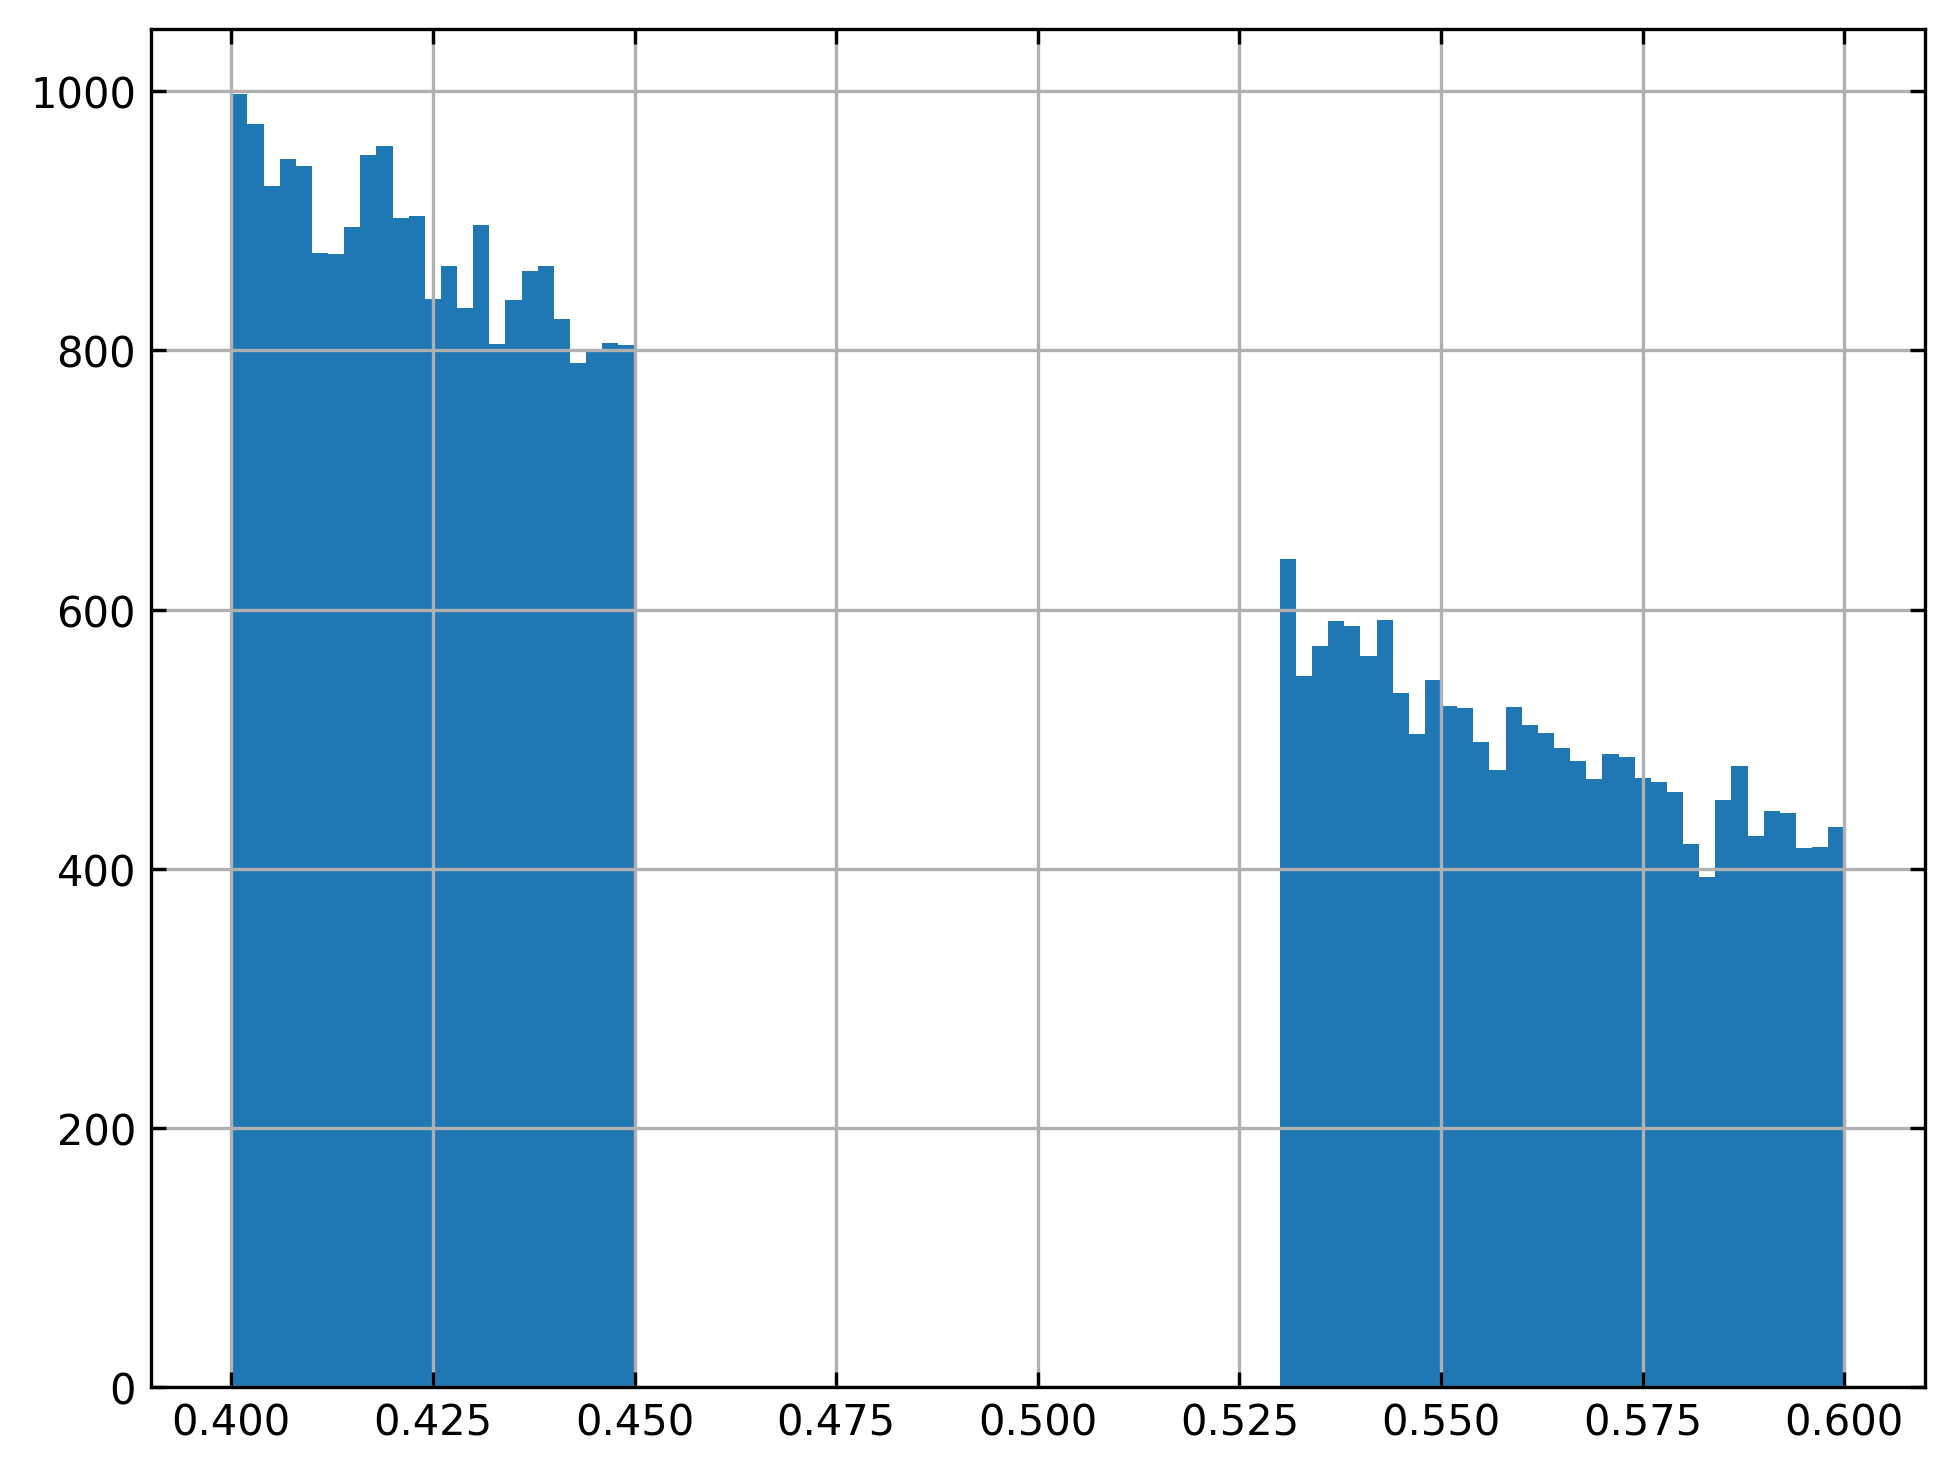

In [9]:
df_background['K_S0_mass'].hist(bins=100)
plt.show()

In [10]:
df_signal[Conf.Category]=1
df_background[Conf.Category]=0

df_signal["Class"]="Signal"
df_background["Class"]="Background"

df_final=pd.concat([df_signal,df_background],ignore_index=True, sort=False)

df_final.head()

,K_S0_mass,K_S0_DIRA,K_S0_decayLength,K_S0_decayLengthErr,track_1_IP_xy,track_2_IP_xy,K_S0_SV_chi2_per_nDoF,K_S0_chi2,track_1_pT,track_2_pT,track_1_pseudorapidity,track_2_pseudorapidity,track_1_phi,track_2_phi,weight,category,Class
0,0.494240,0.998506,5.632285,0.207304,3.031749,-3.193990,0.521330,1.735673,0.289144,0.257066,0.640173,0.654073,-0.601398,1.086975,1.0,1,Signal
1,0.497262,0.999675,2.473175,0.210113,-0.344654,0.408402,-0.000072,0.552522,0.689922,0.728589,0.276925,0.727668,3.041485,2.682203,1.0,1,Signal
2,0.500171,0.999581,3.535844,0.249101,-0.794676,1.037422,0.210227,0.714192,0.854065,0.548361,0.472168,0.323229,2.864274,2.276748,1.0,1,Signal
3,0.489802,0.996862,4.326836,0.264067,-1.254470,2.434513,0.021482,0.134838,0.705663,0.244273,0.033302,0.122813,-0.321799,-1.256091,1.0,1,Signal
4,0.506706,0.999456,3.615499,0.190417,0.666118,-1.768156,0.599268,3.343841,0.916108,0.405810,-0.117135,-0.074235,1.823101,2.502589,1.0,1,Signal


In [11]:
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.TestSize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

/tmp/ipykernel_2651838/3654142783.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


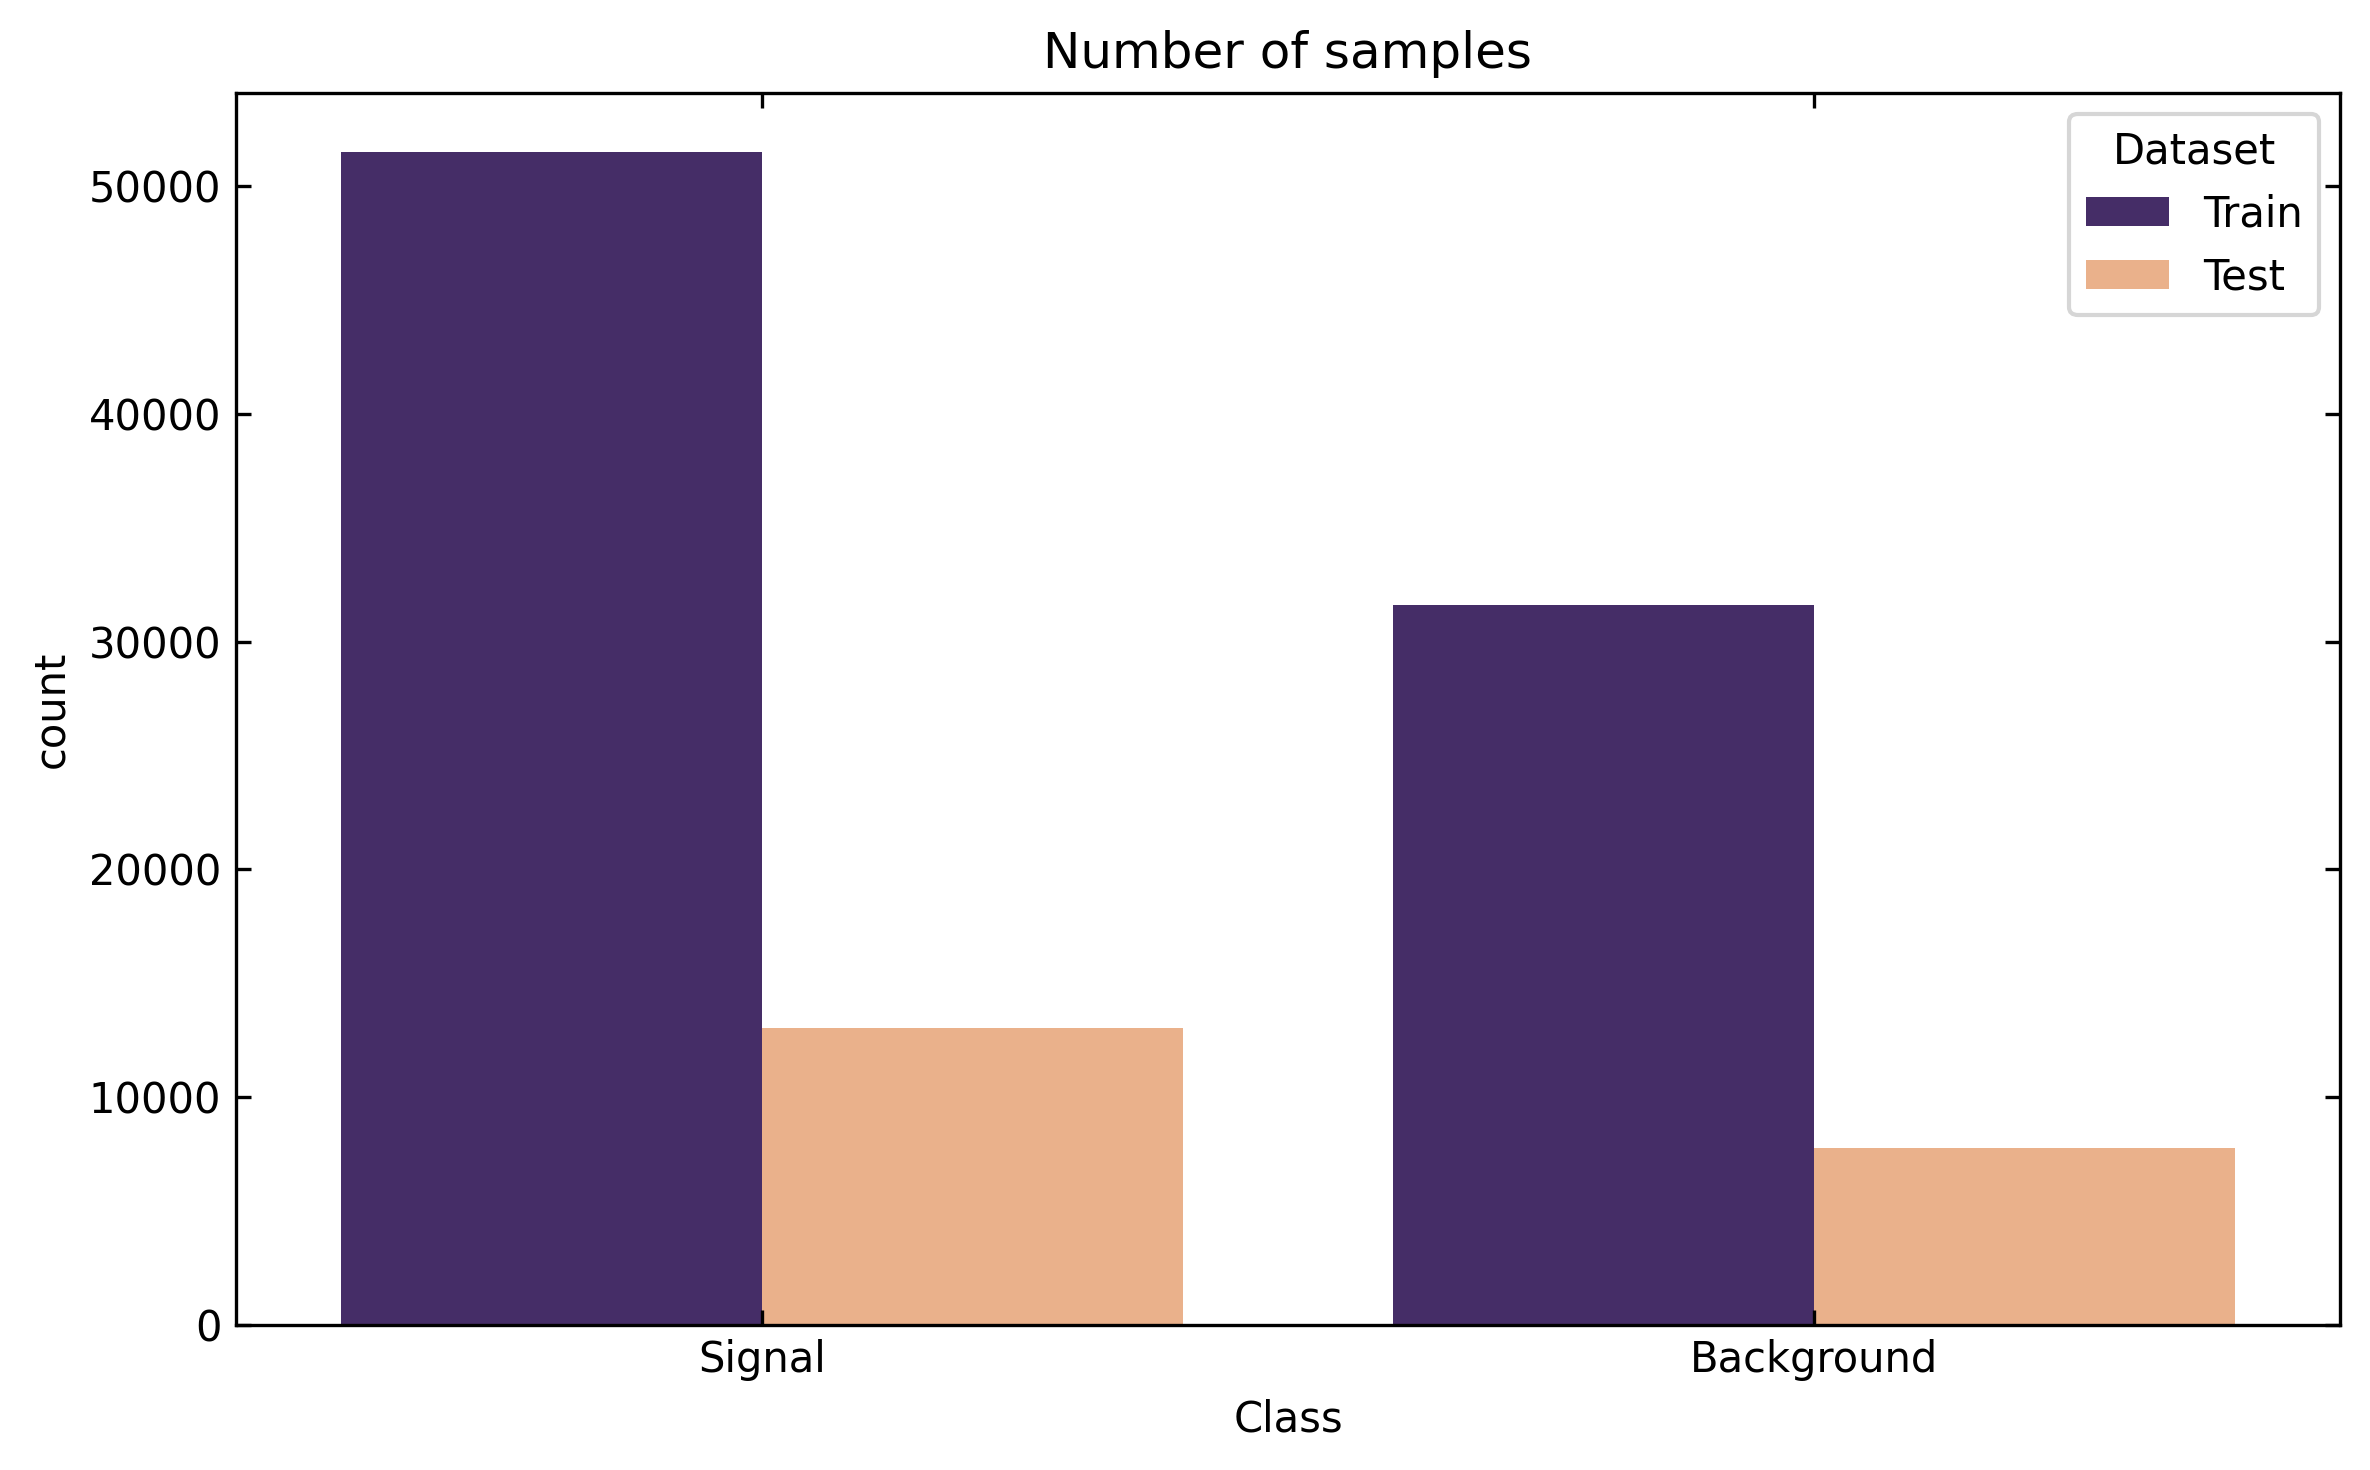

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(x="Class", data=df_final, ax=axes, hue='Dataset', palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.tight_layout()
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")

In [13]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]

    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    Wt_train = np.asarray(Wt_train)
    
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)
    Wt_test = np.asarray(Wt_test)
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test

In [131]:
def plot_roc_curve_root(
    df, score_column, cat, tpr_threshold=0, Wt="weight", MVA="XGB", OutputDirName="Output"
):
    from sklearn import metrics

    list_graph = {}

    for i, t in enumerate(["Train", "Test"]): # Train, Test
        df_temp = df[df["Dataset"] == t]

        fpr, tpr, thresholds = metrics.roc_curve(
            df_temp[cat], df_temp[score_column], sample_weight=df_temp[Wt]
        )
        mask = tpr > tpr_threshold
        fpr, tpr = fpr[mask], tpr[mask]
        auc = metrics.auc(fpr, tpr)  

        # Find the best working point, i.e the point closest to (1,1) of tpr v.s (1-fpr)
        mindist = 1e10
        best_tpr = 0
        best_bkgrej = 0
        tpr = list(map(lambda x: x * 100, tpr))
        bkgrej = list(map(lambda x: (1 - x) * 100, fpr))
        for i in range(len(bkgrej)):
            dist = np.sqrt((100 - tpr[i]) ** 2 + (100 - bkgrej[i]) ** 2)
            if dist < mindist:
                mindist = dist
                best_tpr = tpr[i]
                best_bkgrej = bkgrej[i]

        # get the corresponding prediction threshold
        best_threshold = thresholds[np.argmin(np.abs(tpr - best_tpr))]
        print("Best threshold: {:.3f}".format(best_threshold))
        print("Best TPR: {:.3f}".format(best_tpr))
        print("Best BKG rejection: {:.3f}".format(best_bkgrej))

        # create TGraph
        graph_roc = TGraph(
            len(fpr),
            array.array("d", tpr),
            array.array("d", bkgrej)
        )
        graph_roc.SetLineColor(TColor.GetColor("#4A4947" if t == "Train" else "#FFB22C"))
        graph_roc.SetLineWidth(2)
        linesty = 1 if ("Train" in t) else 2
        print ("linesty=", linesty)
        graph_roc.SetLineStyle(linesty)
        list_graph[f"{t} (Full ROC curve)"] = graph_roc

        graph_best = TGraph(1)
        graph_best.SetPoint(0, best_tpr, best_bkgrej)
        graph_best.SetMarkerStyle(20 if "Train" in t else 21)
        graph_best.SetMarkerSize(1)
        graph_best.SetMarkerColor(TColor.GetColor("#000000" if t == "Train" else "#854836"))
        list_graph["{} (Best WP: threshold={:.3f}, signal eff.={:.1f}%, bkg rej.={:.1f}%)".format(
            t, best_threshold, best_tpr, best_bkgrej)
        ] = graph_best

    # create a canvas
    canvas = TCanvas(f"canvas_{score_column}", f"canvas_{score_column}", 800, 700)
    canvas.cd()
    for i, (key, graph) in enumerate(list_graph.items()):
        print (i, key)
        graph.GetXaxis().SetTitle("Signal Efficiency = TPR (%)")
        graph.GetXaxis().SetTitleOffset(1.3)
        graph.GetYaxis().SetTitle("Background Rejection = 1 - FPR (%)")
        graph.GetYaxis().SetTitleOffset(1.5)
        graph.GetXaxis().SetLimits(-1, 101)
        graph.GetHistogram().SetMinimum(-1)
        graph.GetHistogram().SetMaximum(101)
        if i == 0:
            graph.Draw("AL" if "Full ROC curve" in key else "AP")
        else:
            graph.Draw("L SAME" if "Full ROC curve" in key else "P SAME")
        
    # create a legend
    legend = TLegend(
        gPad.GetLeftMargin() + 0.05,
        gPad.GetBottomMargin() + 0.05,
        gPad.GetLeftMargin() + 0.3,
        gPad.GetBottomMargin() + 0.35
    )
    legend.SetTextSize(0.03)
    legend.SetBorderSize(0)
    legend.SetFillStyle(0)
    for i, (key, graph) in enumerate(list_graph.items()):
        legtext = ""
        if "Best WP" in key:
            # get the string inside the parentheses
            tmptext = key.split(" (")[1].split(")")[0]
            tmptext = tmptext.replace("Best WP: ", "")
            legtext = r"#splitline{Best WP}{%s}" % tmptext

        legend.AddEntry(graph, legtext if "Best WP" in key else key, "l" if "Full ROC curve" in key else "p")

    legend.Draw()
    # save the canvas
    canvas.SaveAs(f"{OutputDirName}/{MVA}/{MVA}_roc_curve.pdf")
    canvas.SaveAs(f"{OutputDirName}/{MVA}/{MVA}_roc_curve.png")
    canvas.Close()
    del canvas

In [ ]:
import pickle
import multiprocessing

for MVA in Conf.MVAs:
    if 'XGB' in MVA:
        MakeFeaturePlotsROOT(df_final, Conf.features[MVA], Conf.FeatureBins, Set="Train", MVA=MVA, OutputDirName=Conf.OutputDirName, cat=Conf.Category, label=["Background","Signal"],weight="weight")
        
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat=Conf.Category,weight="weight")

        # MakeCorrelationMatrix(X, features, MVA, method="pearson", OutputDirName="Output"):
        MakeCorrelationMatrix(X_train, Conf.features[MVA], MVA, "pearson", Conf.OutputDirName)
        
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        import ROOT
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2) #multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        # Extract the best XGBClassifier model
        best_model = search.best_estimator_
        plot_feature_importance(
            model=best_model,
            feature_names=Conf.features[MVA],
            outpath=f"{Conf.OutputDirName}/{MVA}/{MVA}_feature_importance",
            title=f"{MVA} Feature Importance"
        )

        
        pickle.dump(best_model, open(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB.pkl", "wb"))
        # Save model in TMVA format
        # Reference: https://root.cern/doc/master/tmva101__Training_8py.html
        ROOT.TMVA.Experimental.SaveXGBoost(best_model, "BDT", Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB_tmva.root", num_inputs=X_train.shape[1])

        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        prGreen(str(search.best_params_))

        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        plot_mva_root(df_final, MVA+"_pred", Wt="weight", Classes=["Background","Signal"], logy=True, MVA="XGB", OutputDirName=Conf.OutputDirName)
    
        prGreen("Plotting ROC for XGB")
        plot_roc_curve_root(df=df_final, score_column=MVA+"_pred", cat=Conf.Category, tpr_threshold=0, Wt="weight", MVA="XGB", OutputDirName=Conf.OutputDirName)

 Making Train dataset feature plots with ROOT
 XGB Training starting
 Performing XGB grid search
Fitting 3 folds for each of 1 candidates, totalling 3 fits


## Load the XGBoost model using TMVA

/tmp/ipykernel_2651838/1106943172.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


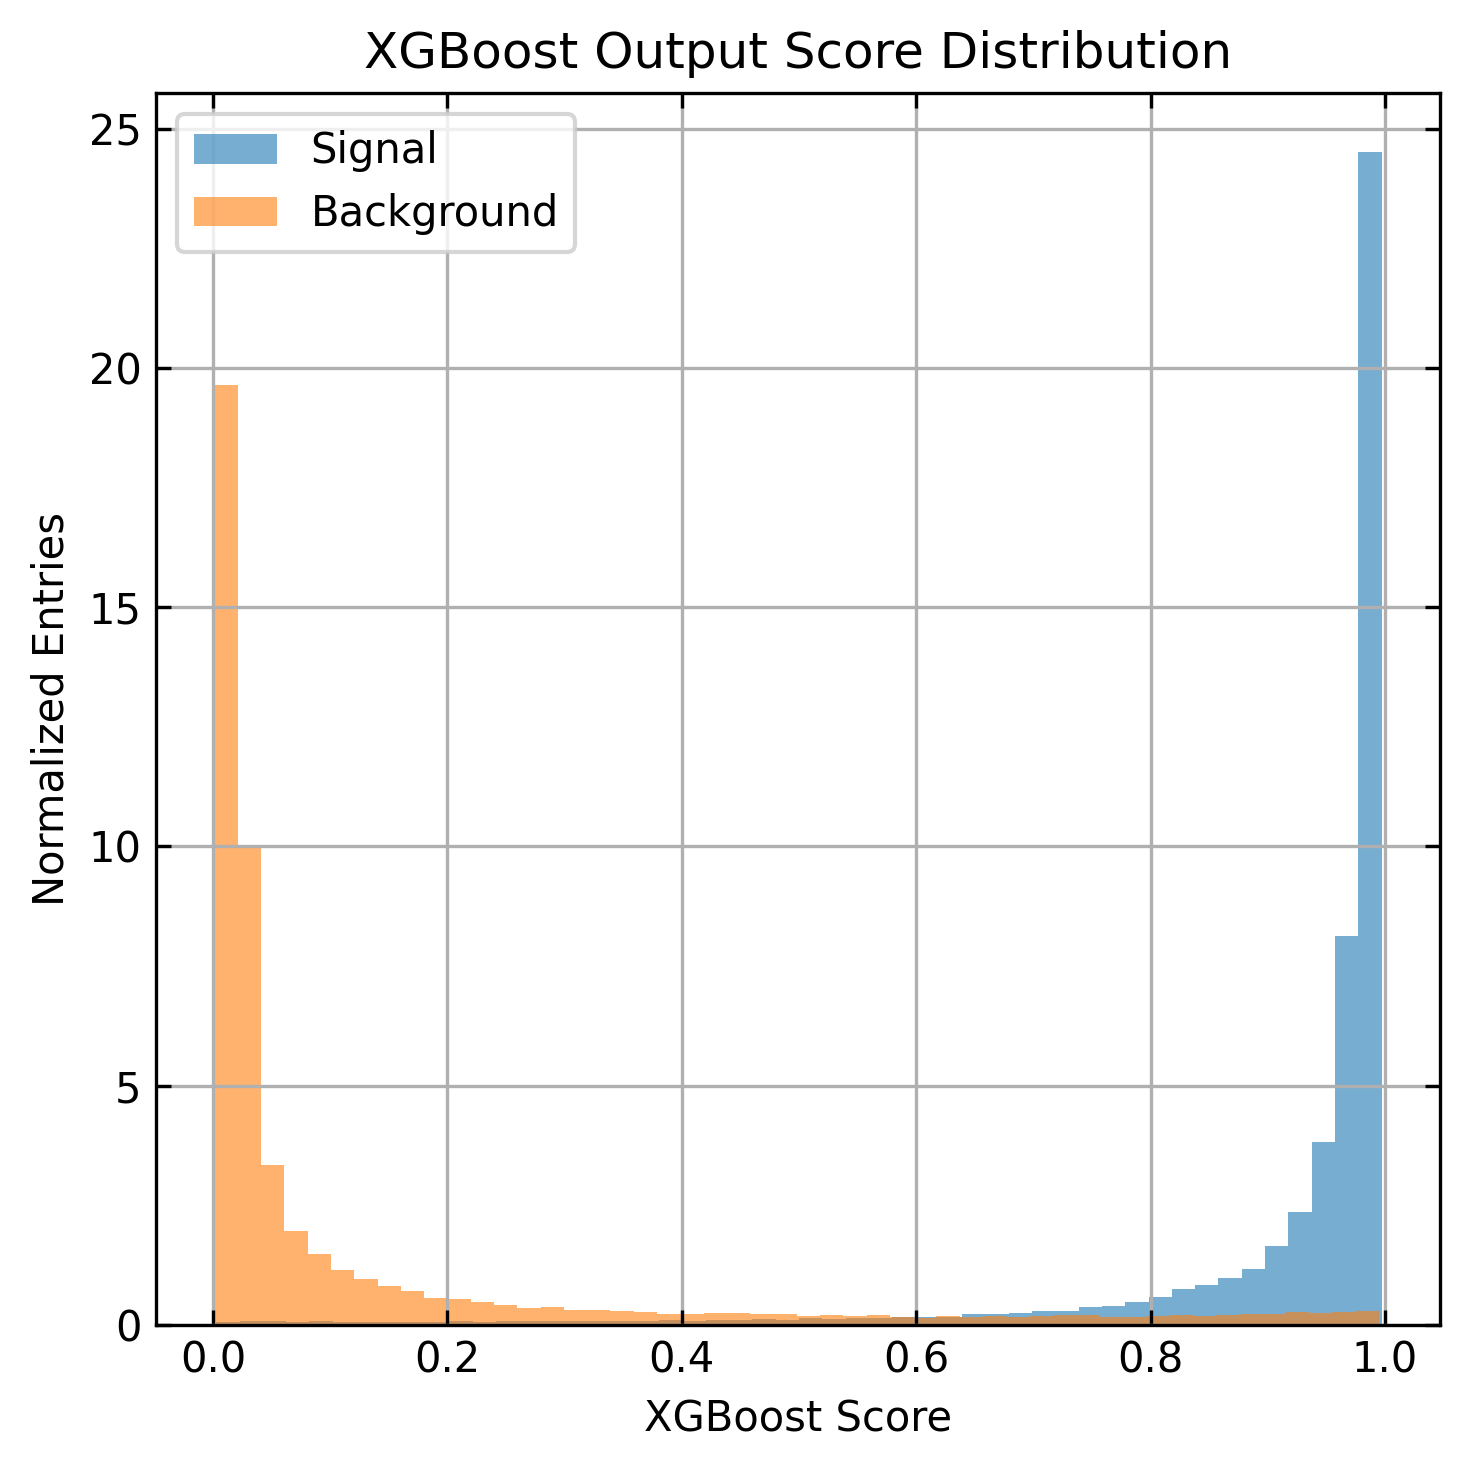

In [15]:
Value_t = ROOT.TMVA.Experimental.RBDT.Value_t
FloatVec = ROOT.std.vector[Value_t]

def predict_batch(model, X):
    X_np = X.to_numpy(dtype=np.float32) if isinstance(X, pd.DataFrame) else X.astype(np.float32)
    preds = []
    for row in X_np:
        vec = FloatVec()
        for val in row:
            vec.push_back(Value_t(val))
        y_vec = model.Compute(vec)
        y = float(y_vec[0])
        preds.append(y)
    return np.array(preds)

for MVA in Conf.MVAs:
    if 'XGB' in MVA:
        ModelFile=Conf.OutputDirName+"/"+MVA+"/"+MVA+"_modelXGB_tmva.root"

        model = ROOT.TMVA.Experimental.RBDT("BDT", ModelFile)

        y_pred_train = predict_batch(model, X_train)
        y_pred_test = predict_batch(model, X_test)

        y_pred_signal = y_pred_train[Y_train == 1]
        y_pred_bkg = y_pred_train[Y_train == 0]

        plt.figure(figsize=(5, 5))
        plt.hist(y_pred_signal, bins=50, alpha=0.6, label="Signal", density=True, histtype='stepfilled')
        plt.hist(y_pred_bkg, bins=50, alpha=0.6, label="Background", density=True, histtype='stepfilled')
        
        plt.xlabel("XGBoost Score")
        plt.ylabel("Normalized Entries")
        plt.title("XGBoost Output Score Distribution")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()